<a href="https://colab.research.google.com/github/mrrkdas/Mini-Projects/blob/main/Transfer_Learning_with_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Tensorflow imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Other imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Getting the Data
classes = ['cat', 'dog'] 
split = ['train[:70%]', 'train[70%:]']

train_data, test_data = tfds.load(name = 'cats_vs_dogs', split = split, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteXD0E62/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## Getting to know the data

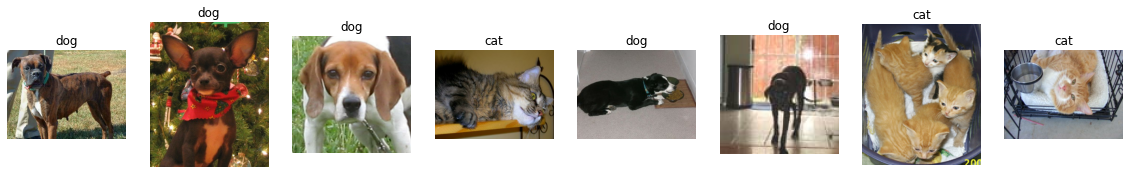

In [3]:
# plt.figure(figsize = (12, 9))

i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in train_data.take(8):
    # plt.figure(figsize = (12, 9)) 
    ax[i].axis('off')
    ax[i].set_title(classes[label])
    ax[i].imshow(image)
    i += 1
 
plt.show()

## Preprocessing

In [7]:
def preprocess_images(img, label, height = 224, width = 224):
  """ This function resizes the images, and return the label along with the image

  Parameters:
      height: the height to reisize the image
      width: the width to resize the image """ 

  image  = tf.image.resize(img, [height, width]) / 255 # Resizing and making the image standardized

  return image, label

In [8]:
# Defining height and width 
height = 224
width = 224

In [9]:
# Mapping preprocess_images to train and test data, along with batching the data, and prefetching the data
train_data = train_data.map(preprocess_images).batch(64).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_images).batch(64).prefetch(tf.data.AUTOTUNE)

## Model using MobileNetV_2

In [10]:
# Mobile Net URL
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [11]:
# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(mobilenet_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(height, width)+(3,)) # define the input image shape

In [12]:
 model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

In [13]:
model.compile(loss = 'binary_crossentropy',  optimizer = 'adam', metrics = ['accuracy'])

In [14]:
mobilenet_history = model.fit(train_data, epochs = 3, validation_data = test_data)

Epoch 1/3
255/255 [==============================] - 68s 211ms/step - loss: 0.0950 - accuracy: 0.9701 - val_loss: 0.0402 - val_accuracy: 0.9884
Epoch 2/3
255/255 [==============================] - 53s 206ms/step - loss: 0.0374 - accuracy: 0.9888 - val_loss: 0.0330 - val_accuracy: 0.9887
Epoch 3/3
255/255 [==============================] - 53s 206ms/step - loss: 0.0312 - accuracy: 0.9904 - val_loss: 0.0306 - val_accuracy: 0.9893


## After Model

In [15]:
def plot_metrics(history, accuracy = 'accuracy', validation_accuracy = 'val_accuracy'):
  """ Plots loss, and accuracy. 

  Parameter:

    history: model.fit()
    accuracy: the type of accuracy (could vary for sum situations)
    validation_accuracy: type of validation accuracy (could vary for some situations) """

  plt.plot(history.history['loss'], label = "Loss")
  plt.plot(history.history['val_loss'], label = 'Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Vs. Epochs')
  plt.legend()
  plt.show()

  plt.plot(history.history[accuracy], label = "Accuracy")
  plt.plot(history.history[validation_accuracy], label = 'Validation Accuracy')
  plt.xlabel('Epcohs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Vs. Epochs')
  plt.legend()
  plt.show()

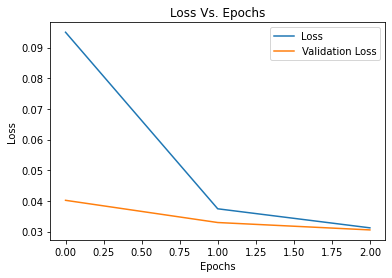

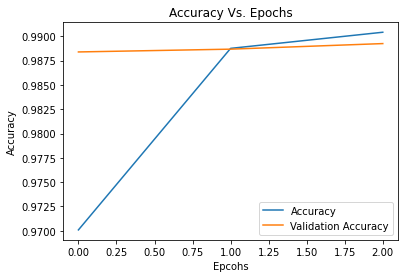

In [16]:
plot_metrics(mobilenet_history)

In [17]:
# Evaluate Model
mobilenet_results = model.evaluate(test_data)

110/110 [==============================] - 16s 144ms/step - loss: 0.0306 - accuracy: 0.9893


In [51]:
# Predictions
preds = model.predict(test_data)

In [53]:
preds = np.round_(preds)

In [19]:
test_data_unbatched = test_data.unbatch()

In [20]:
images = []
labels = []

for image, label in test_data_unbatched:
  images.append(image)
  labels.append(label)

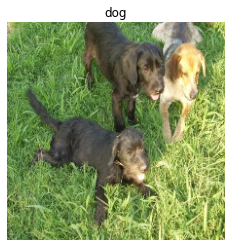

In [57]:
plt.imshow(images[1])
plt.title(classes[int(preds[1])])
plt.axis('off')
plt.show()

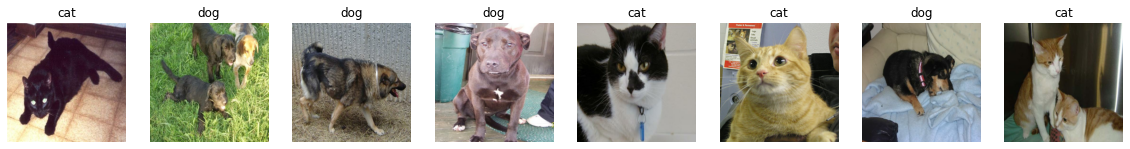

In [59]:
i = 0
fig, ax = plt.subplots(1, 8, figsize = (20, 20))
for image, label in test_data_unbatched.take(8):
    ax[i].axis('off')
    ax[i].set_title(classes[int(preds[i])])
    # ax[i].s
    ax[i].imshow(image)
    i += 1
 
plt.show()